# Imports

In [6]:
import functools
import os
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm, trange

from diffusion_policy.common.normalize_util import get_image_range_normalizer
from diffusion_policy.common.pytorch_util import compute_conv_output_shape
from diffusion_policy.common.sampler import get_val_mask
from diffusion_policy.dataset.pusht_image_dataset import PushTImageDataset
from diffusion_policy.model.common.normalizer import (
    LinearNormalizer,
    SingleFieldLinearNormalizer,
)
from vae.pusht_vae import VanillaVAE

# Load dataset

In [7]:
path = "/nas/ucb/ebronstein/lsdp/diffusion_policy/data/pusht/pusht_cchi_v7_replay.zarr"
dataset = PushTImageDataset(path)

In [8]:
episode = dataset.replay_buffer.get_episode(0)
episode.keys()
print("episode['img']:", episode['img'].shape)
print("episode['action']:", episode['action'].shape)

episode['img']: (161, 96, 96, 3)
episode['action']: (161, 2)


/nas/ucb/ebronstein/anaconda3/envs/lsdp/lib/python3.9/site-packages/matplotlib/text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


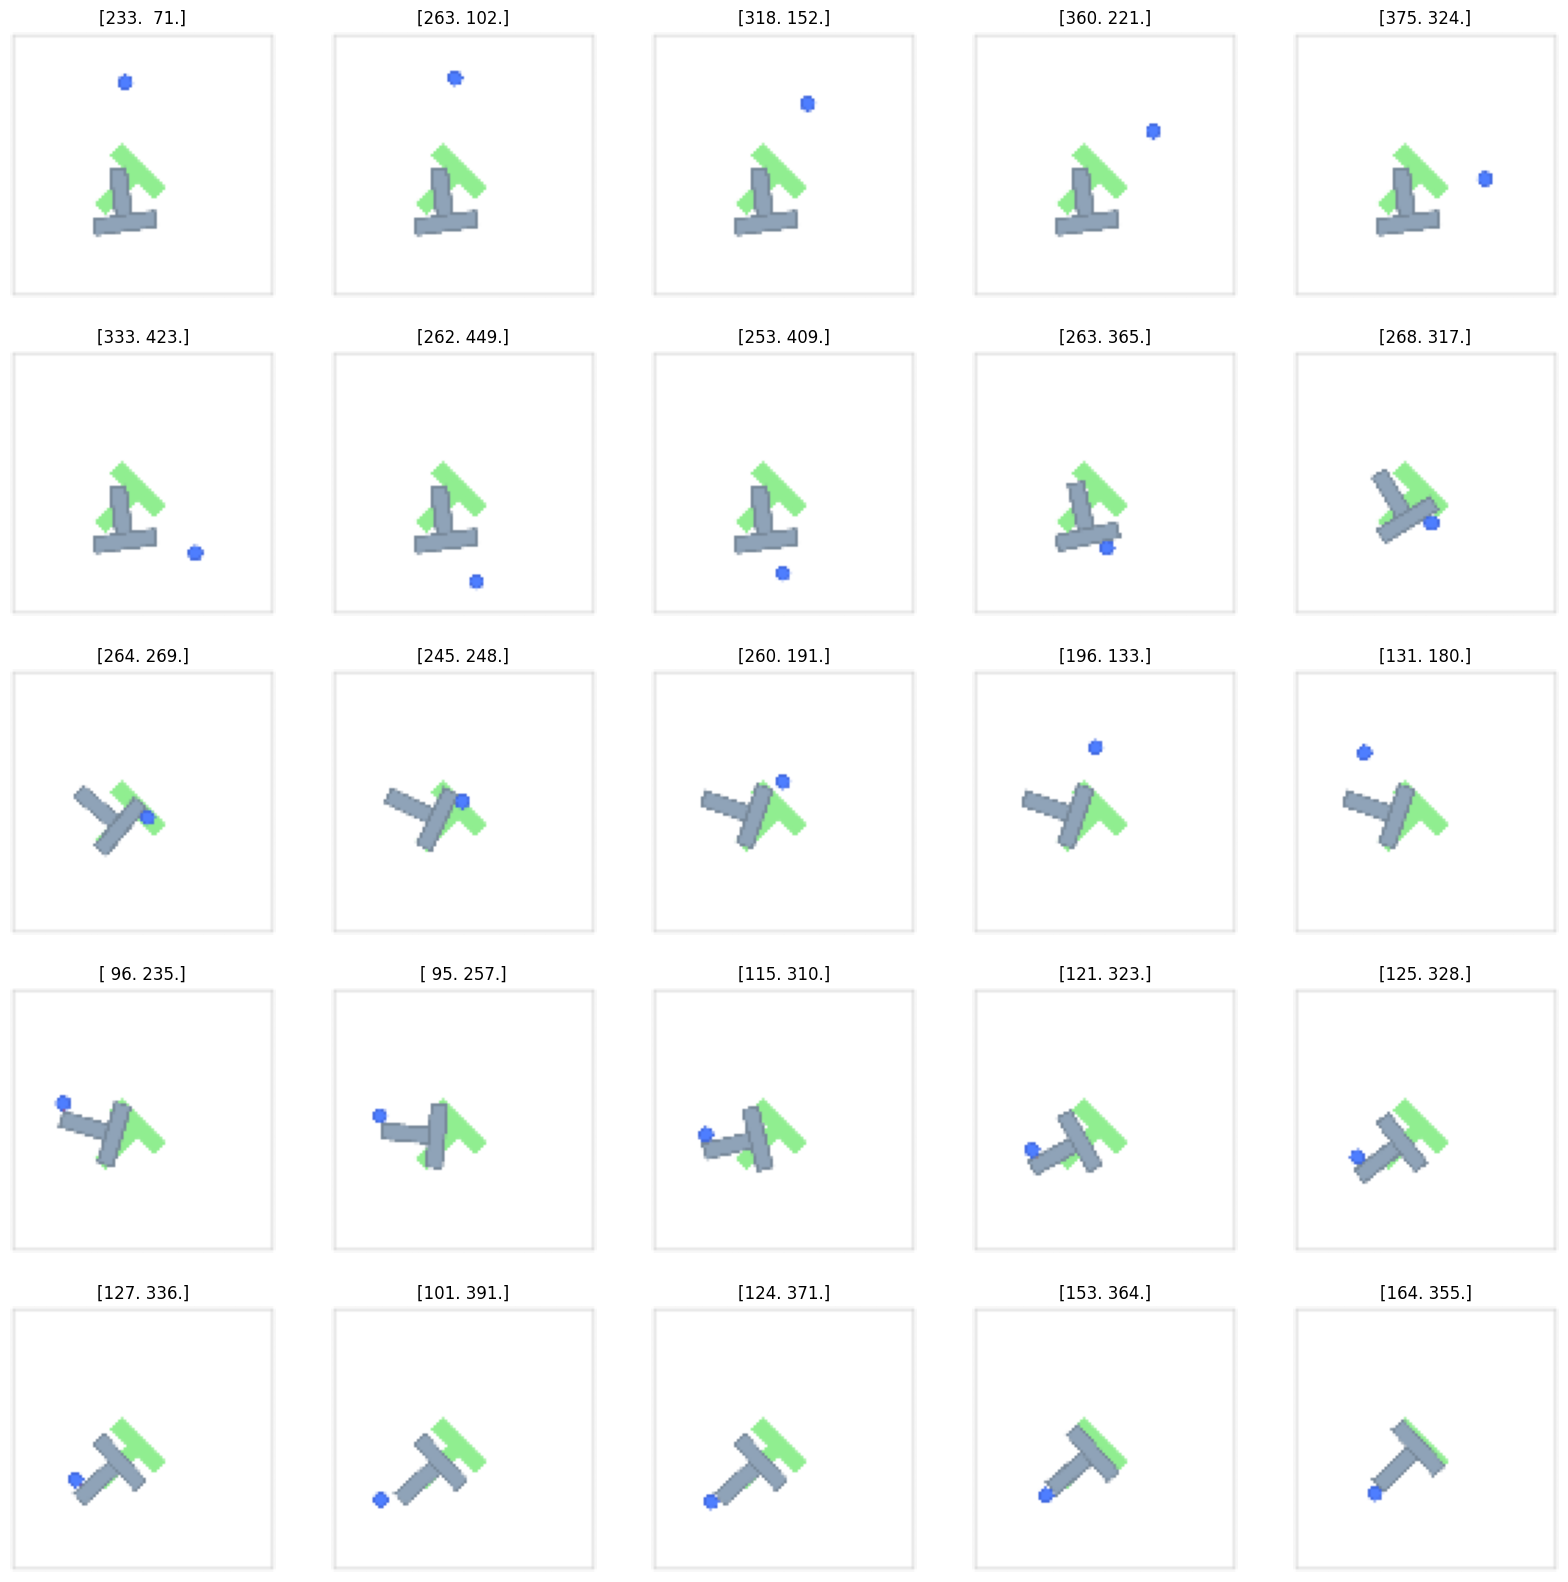

In [9]:
# Visualize subset of the episode
episode_len = episode["img"].shape[0]
time_steps = np.linspace(0, episode_len - 1, 25).astype(int)
# Plot the first few images and actions in the episode
fig, axs = plt.subplots(5, 5, figsize=(20, 20))
for i, step in enumerate(time_steps):
    ax = axs[i // 5, i % 5]
    ax.imshow(episode["img"][step] / 255.0)
    ax.set_title(episode["action"][step])
    ax.axis("off")

# Load VAE

In [10]:
# Load the VAE
img_data = torch.from_numpy(dataset.replay_buffer["img"]).permute(0, 3, 1, 2).float()
N, C, H, W = img_data.shape
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VanillaVAE(in_channels=C, in_height=H, in_width=W, latent_dim=32).to(device)
save_dir = "models/pusht_vae"
vae.load_state_dict(torch.load(os.path.join(save_dir, "vae_32_20240403.pt")))

<All keys matched successfully>

# Encode dataset with VAE

In [11]:
def encode_images(img, img_normalizer, vae, device):
    img = img_normalizer(img / 255.0)
    with torch.no_grad():
        mu, log_var = vae.encode(img.to(device))
    return mu.cpu().detach().numpy()

In [12]:
# Encode the full dataset by batches to avoid CUDA OOM.
img_normalizer = get_image_range_normalizer()
batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mu_list = []
vae.eval()
for i in trange(0, N, batch_size):
    img_batch = img_data[i : i + batch_size]
    batch_mu = encode_images(img_batch, img_normalizer, vae, device)
    mu_list.append(batch_mu)

encoded_imgs = np.concatenate(mu_list, axis=0)

  0%|          | 0/201 [00:00<?, ?it/s]

# Data normalizers

In [13]:
# Make the latent image normalizer
encoded_imgs_mean = encoded_imgs.mean(axis=0)
encoded_imgs_std = encoded_imgs.std(axis=0)

encoded_imgs_scale = (1.0 / encoded_imgs_std).astype(np.float32)
encoded_imgs_offset = -encoded_imgs_mean / encoded_imgs_std
encoded_imgs_stat = {
    "mean": encoded_imgs_mean,
    "std": encoded_imgs_std,
    "min": encoded_imgs.min(axis=0),
    "max": encoded_imgs.max(axis=0),
}
latent_img_normalizer = SingleFieldLinearNormalizer.create_manual(
    scale=encoded_imgs_scale,
    offset=encoded_imgs_offset,
    input_stats_dict=encoded_imgs_stat,
)

# Make the action normalizer.
action_normalizer = LinearNormalizer()
action_normalizer.fit(
    data=dataset.replay_buffer["action"], last_n_dims=1, mode="limits"
)

# Episode Dataset

In [14]:
import torch
from torch.utils.data import Dataset


class EpisodeDataset(Dataset):
    def __init__(
        self,
        dataset,
        n_obs_history=1,
        n_pred_horizon=1,
        episode_idxs=None,
        process_img_fn=None,
    ):
        """
        Initialize the dataset with the main dataset object that contains
        the replay_buffer. Also, specify the lengths of observation history
        and prediction horizon.
        """
        self.dataset = dataset
        self.n_obs_history = n_obs_history
        self.n_pred_horizon = n_pred_horizon
        self.episode_idxs = episode_idxs
        self.process_img_fn = process_img_fn
        self.prepare_data()

    def prepare_data(self):
        """
        Preprocess the episodes to create a flat list of samples.
        Each sample is a tuple of dictionaries: (obs_history, pred_horizon).
        """
        self.samples = []

        if self.episode_idxs is None:
            self.episode_idxs = range(self.dataset.replay_buffer.n_episodes)

        for episode_idx in tqdm(self.episode_idxs, desc="Preparing data"):
            episode = self.dataset.replay_buffer.get_episode(episode_idx)
            img = episode["img"].transpose(0, 3, 1, 2)  # CHW format
            if self.process_img_fn is not None:
                img = self.process_img_fn(img)
            actions = episode["action"]

            # Iterate through the episode to create samples with observation history and prediction horizon
            for i in range(len(actions) - self.n_obs_history - self.n_pred_horizon + 1):
                obs_history_imgs = img[i : i + self.n_obs_history]
                obs_history_actions = actions[i : i + self.n_obs_history]

                pred_horizon_imgs = img[
                    i
                    + self.n_obs_history : i
                    + self.n_obs_history
                    + self.n_pred_horizon
                ]
                pred_horizon_actions = actions[
                    i
                    + self.n_obs_history : i
                    + self.n_obs_history
                    + self.n_pred_horizon
                ]

                obs_history = {"img": obs_history_imgs, "action": obs_history_actions}
                pred_horizon = {
                    "img": pred_horizon_imgs,
                    "action": pred_horizon_actions,
                }

                self.samples.append((obs_history, pred_horizon))

    def __len__(self):
        """
        Return the total number of samples across all episodes.
        """
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Return the idx-th sample from the dataset.
        """
        obs_history, pred_horizon = self.samples[idx]

        # Convert data to PyTorch tensors and ensure the data type is correct
        obs_history["img"] = torch.tensor(obs_history["img"], dtype=torch.float32)
        obs_history["action"] = torch.tensor(obs_history["action"], dtype=torch.float32)
        pred_horizon["img"] = torch.tensor(pred_horizon["img"], dtype=torch.float32)
        pred_horizon["action"] = torch.tensor(
            pred_horizon["action"], dtype=torch.float32
        )

        return obs_history, pred_horizon

In [10]:
# class EpisodeDataset(torch.utils.data.Dataset):
#     def __init__(self, dataset, episode_idxs=None, process_img_fn=None):
#         """
#         Initialize the dataset with the main dataset object that contains
#         the replay_buffer.
#         """
#         self.dataset = dataset
#         self.episode_idxs = episode_idxs
#         self.process_img_fn = process_img_fn
#         self.prepare_data()

#     def prepare_data(self):
#         """
#         Preprocess the episodes to create a flat list of samples.
#         Each sample is a tuple: (current_image, next_image, action).
#         """
#         self.samples = []

#         if self.episode_idxs is None:
#             self.episode_idxs = range(self.dataset.replay_buffer.n_episodes)

#         for episode_idx in self.episode_idxs:
#             episode = self.dataset.replay_buffer.get_episode(episode_idx)
#             img = episode["img"].transpose(0, 3, 1, 2)
#             if self.process_img_fn is not None:
#                 img = self.process_img_fn(img)
#             actions = episode["action"]

#             # Ensure there is a next image for each current image
#             assert len(img) == len(actions)

#             for i in range(len(actions) - 1):
#                 self.samples.append((img[i], img[i + 1], actions[i]))

#     def __len__(self):
#         """
#         Return the total number of samples across all episodes.
#         """
#         return len(self.samples)

#     def __getitem__(self, idx):
#         """
#         Return the idx-th sample from the dataset.
#         """
#         current_img, next_img, action = self.samples[idx]

#         # Convert data to PyTorch tensors and ensure the data type is correct
#         current_img_tensor = torch.tensor(current_img, dtype=torch.float32)
#         next_img_tensor = torch.tensor(next_img, dtype=torch.float32)
#         action_tensor = torch.tensor(action, dtype=torch.float32)

#         return current_img_tensor, next_img_tensor, action_tensor

# Make dataloaders

In [54]:
# Make train and val loaders
val_mask = get_val_mask(dataset.replay_buffer.n_episodes, 0.1)
val_idxs = np.where(val_mask)[0]
train_idxs = np.where(~val_mask)[0]

# Make the episode dataset and create a DataLoader.
batch_size = 256
n_obs_history = 5
n_pred_horizon = 0
process_img_fn = functools.partial(
    encode_images, img_normalizer=img_normalizer, model=model, device=device
)
train_episode_dataset = EpisodeDataset(
    dataset,
    n_obs_history=n_obs_history,
    n_pred_horizon=n_pred_horizon,
    episode_idxs=train_idxs,
    process_img_fn=process_img_fn,
)
val_episode_dataset = EpisodeDataset(
    dataset,
    n_obs_history=n_obs_history,
    n_pred_horizon=n_pred_horizon,
    episode_idxs=val_idxs,
    process_img_fn=process_img_fn,
)
train_loader = torch.utils.data.DataLoader(
    train_episode_dataset, batch_size=batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_episode_dataset, batch_size=batch_size, shuffle=False
)

Preparing data:   0%|          | 0/185 [00:00<?, ?it/s]

Preparing data:   0%|          | 0/21 [00:00<?, ?it/s]

In [55]:
obs_history, pred_horizon = next(iter(train_loader))
for k, v in obs_history.items():
    print(f"obs_history['{k}']", v.shape)
for k, v in pred_horizon.items():
    print(f"pred_horizon['{k}']", v.shape)

obs_history['img'] torch.Size([256, 5, 32])
obs_history['action'] torch.Size([256, 5, 2])
pred_horizon['img'] torch.Size([256, 0, 32])
pred_horizon['action'] torch.Size([256, 0, 2])


# Models

In [15]:
class InverseDynamicsMLP(nn.Module):
    def __init__(
        self, n_obs: int, obs_dim: int, action_dim: int, hidden_dims: list[int]
    ):
        super().__init__()

        layers = []
        in_dim = n_obs * obs_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, hidden_dim))
            layers.append(nn.ReLU())
            in_dim = hidden_dim
        layers.append(nn.Linear(in_dim, action_dim))
        layers.append(nn.Tanh())
        self.model = nn.Sequential(*layers)

    def forward(self, obs_history: torch.Tensor) -> torch.Tensor:
        x = obs_history.flatten(start_dim=1)
        x = self.model(x)
        return x

In [49]:
class InverseDynamicsCNN(nn.Module):
    def __init__(
        self,
        in_channels: int,
        in_height: int,
        in_width: int,
        action_dim: int,
        n_obs_history: int,
        hidden_dims: list[int] = None,
    ):
        super(InverseDynamicsCNN, self).__init__()

        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        modules = []
        kernel_size = 3
        stride = 2
        padding = 1
        dilation = 1
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(
                        in_channels,
                        out_channels=h_dim,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=padding,
                        dilation=dilation,
                    ),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU(),
                )
            )
            in_channels = h_dim

        # Define the initial part of the CNN that processes individual images
        self.conv_branch = nn.Sequential(
            *modules,
            # Flatten the output for the dense layers
            nn.Flatten(),
        )

        # Compute the shape of the output of the convolutional branch before it
        # is flattened and passed through the dense layers.
        conv_out_shape = compute_conv_output_shape(
            H=in_height,
            W=in_width,
            padding=padding,
            stride=stride,
            kernel_size=kernel_size,
            dilation=dilation,
            num_layers=len(hidden_dims),
            last_hidden_dim=hidden_dims[-1],
        )
        conv_out_size = np.prod(conv_out_shape)

        # Define the part of the network that combines features and predicts the action
        self.action_predictor = nn.Sequential(
            nn.Linear(n_obs_history * conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim),
            nn.Tanh(),
        )

    def forward(self, obs_history: torch.Tensor):
        """Forward pass.

        Args:
            obs_history (torch.Tensor): Observation history of shape (batch_size, n_obs, C, H, W).
        """
        # List to hold the features extracted from each image in the observation history
        features_list = []

        # Iterate over the second dimension (n_obs) of the obs_history tensor
        for i in range(obs_history.size(1)):
            # Extract the i-th image from the observation history
            img_i = obs_history[:, i]

            # Process the image through the convolutional branch
            img_i_features = self.conv_branch(img_i)

            # Append the features to the list
            features_list.append(img_i_features)

        # Concatenate the features from all images along the feature dimension (dim=1)
        combined_features = torch.cat(features_list, dim=1)

        # Predict the action from the combined features
        action_pred = self.action_predictor(combined_features)
        return action_pred

# Data normalizers

In [18]:
# Sanity check image normalization
img = dataset.replay_buffer.get_episode(0)["img"].transpose(0, 3, 1, 2)
encoded_img = encode_images(img, img_normalizer, vae, device)
print("img.shape:", img.shape)
print("encoded_img.shape:", encoded_img.shape)

print("encoded_img.mean():", encoded_img.mean())
print("encoded_img.std():", encoded_img.std())
normalized_encoded_img = latent_img_normalizer(encoded_img)
print("normalized_encoded_img.mean():", normalized_encoded_img.mean())
print("normalized_encoded_img.std():", normalized_encoded_img.std())

# Sanity check action normalization
action = dataset.replay_buffer.get_episode(0)["action"]
normalized_action = action_normalizer(action)
print("action.min():", action.min())
print("action.max():", action.max())
print("normalized_action.min():", normalized_action.min())
print("normalized_action.max():", normalized_action.max())

img.shape: (161, 3, 96, 96)
encoded_img.shape: (161, 32)
encoded_img.mean(): -0.015567426
encoded_img.std(): 1.644177
normalized_encoded_img.mean(): tensor(-0.0010, grad_fn=<MeanBackward0>)
normalized_encoded_img.std(): tensor(1.0122, grad_fn=<StdBackward0>)
action.min(): 71.0
action.max(): 449.0
normalized_action.min(): tensor(-0.8107)
normalized_action.max(): tensor(0.7449)


# Training and eval

In [19]:
def train_epochs(
    model,
    train_loader,
    val_loader,
    obs_normalizer,
    action_normalizer,
    opt_kwargs: Optional[dict] = None,
    num_epochs=10,
    log_freq: Optional[int] = None,
    save_freq=2,
    save_dir: Optional[str] = None,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.MSELoss()
    opt_kwargs = opt_kwargs or {}
    optimizer = torch.optim.Adam(model.parameters(), **opt_kwargs)

    train_losses = []
    test_losses = []
    with trange(num_epochs, desc="Epoch") as tepoch:
        for epoch in tepoch:
            model.train()
            with tqdm(train_loader, desc="Batch") as tbatch:
                # Prediction horizon is unused.
                for i, (obs_history, _) in enumerate(tbatch):
                    obs = obs_history["img"]
                    # The second-to-last action is the target action because it was
                    # applied to get the last image.
                    action = obs_history["action"][:, -2]

                    # Normalize image and action.
                    obs = obs_normalizer(obs)
                    action = action_normalizer(action)

                    obs = obs.to(device)
                    action = action.to(device)

                    optimizer.zero_grad()
                    action_pred = model(obs)
                    loss = criterion(action_pred, action)
                    loss.backward()
                    optimizer.step()

                    loss_cpu = loss.item()
                    train_losses.append(loss_cpu)

                    tbatch.set_postfix(loss=loss_cpu)
                    if log_freq is not None and (i % log_freq == 0):
                        print(f"Epoch {epoch}, Batch {i}, Train Loss: {loss_cpu}")

            # Eval
            test_loss = eval(
                model, val_loader, obs_normalizer, action_normalizer, criterion, device
            )
            test_losses.append(test_loss)
            tepoch.set_postfix(test_loss=test_loss)

            # Save
            if save_dir is not None and (
                epoch % save_freq == 0 or epoch == num_epochs - 1
            ):
                epoch_str = "final" if epoch == num_epochs - 1 else str(epoch)
                torch.save(
                    model.state_dict(),
                    os.path.join(save_dir, f"inverse_dynamics_{epoch_str}.pt"),
                )

    return train_losses, test_losses


def eval(model, val_loader, obs_normalizer, action_normalizer, criterion, device):
    model.eval()
    test_losses = []
    with torch.no_grad():
        for obs_history, _ in val_loader:
            obs = obs_history["img"]
            # The second-to-last action is the target action because it was
            # applied to get the last image.
            action = obs_history["action"][:, -2]

            obs = obs_normalizer(obs).to(device)
            action = action_normalizer(action).to(device)

            action_pred = model(obs)
            loss = criterion(action_pred, action)
            # Multiply the loss by the number of samples in the batch.
            test_losses.append(loss.item() * obs.shape[0])

    # Compute the average loss across all batches.
    test_loss = np.sum(test_losses) / len(val_loader.dataset)
    return test_loss


def plot_losses(train_losses, test_losses):
    # Plot train and test losses.
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(
        np.linspace(0, len(train_losses), len(test_losses)),
        test_losses,
        label="Test Loss",
    )
    # Remove outliers for better visualization
    # plt.ylim(0, 0.01)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Train MLP

In [ ]:
# Make train and val loaders
val_mask = get_val_mask(dataset.replay_buffer.n_episodes, 0.1)
val_idxs = np.where(val_mask)[0]
train_idxs = np.where(~val_mask)[0]

# Make the episode dataset and create a DataLoader.
batch_size = 256
n_obs_history = 5
n_pred_horizon = 0
process_img_fn = functools.partial(
    encode_images, img_normalizer=img_normalizer, vae=vae, device=device
)
train_episode_dataset = EpisodeDataset(
    dataset,
    n_obs_history=n_obs_history,
    n_pred_horizon=n_pred_horizon,
    episode_idxs=train_idxs,
    process_img_fn=process_img_fn,
)
val_episode_dataset = EpisodeDataset(
    dataset,
    n_obs_history=n_obs_history,
    n_pred_horizon=n_pred_horizon,
    episode_idxs=val_idxs,
    process_img_fn=process_img_fn,
)
train_loader = torch.utils.data.DataLoader(
    train_episode_dataset, batch_size=batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_episode_dataset, batch_size=batch_size, shuffle=False
)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
id_model = InverseDynamicsMLP(
    n_obs=n_obs_history, obs_dim=32, action_dim=2, hidden_dims=[256, 256, 256]
).to(device)
train_losses, test_losses = train_epochs(
    id_model,
    train_loader,
    val_loader,
    latent_img_normalizer,
    action_normalizer,
    opt_kwargs={"lr": 1e-3, "weight_decay": 1e-5},
    num_epochs=10,
    log_freq=None,
    save_freq=2,
    save_dir=None,
)

Preparing data:   0%|          | 0/185 [00:00<?, ?it/s]

Preparing data:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/88 [00:00<?, ?it/s]

Batch:   0%|          | 0/88 [00:00<?, ?it/s]

/tmp/ipykernel_3746688/2594059924.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs_history["img"] = torch.tensor(obs_history["img"], dtype=torch.float32)
/tmp/ipykernel_3746688/2594059924.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs_history["action"] = torch.tensor(obs_history["action"], dtype=torch.float32)
/tmp/ipykernel_3746688/2594059924.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_horizon["img"] = torch.tensor(pred_horizon["img"], dtype=torch.float32)
/tmp/ipykernel_3746688/2594059924.py:85: UserWarni

Batch:   0%|          | 0/88 [00:00<?, ?it/s]

Batch:   0%|          | 0/88 [00:00<?, ?it/s]

Batch:   0%|          | 0/88 [00:00<?, ?it/s]

Batch:   0%|          | 0/88 [00:00<?, ?it/s]

Batch:   0%|          | 0/88 [00:00<?, ?it/s]

Batch:   0%|          | 0/88 [00:00<?, ?it/s]

Batch:   0%|          | 0/88 [00:00<?, ?it/s]

Batch:   0%|          | 0/88 [00:00<?, ?it/s]

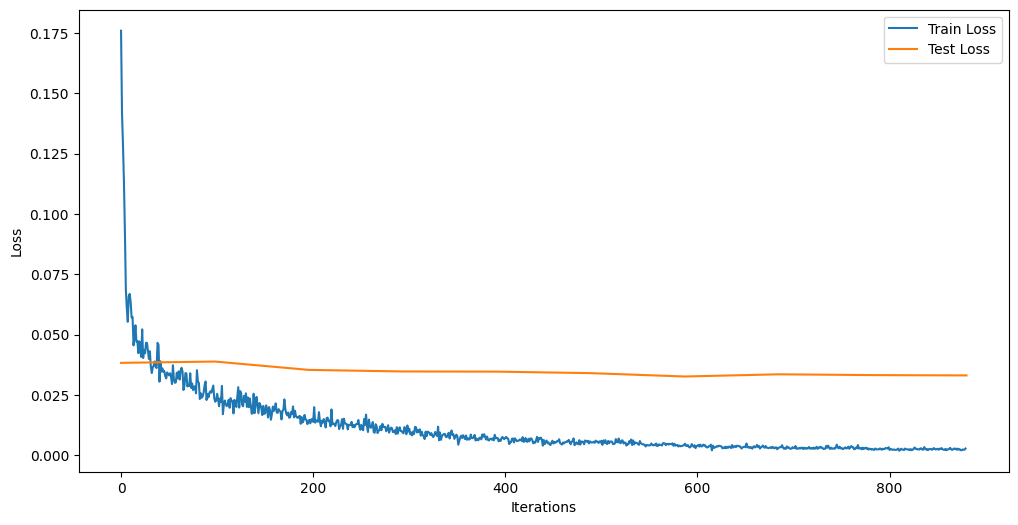

In [22]:
plot_losses(train_losses, test_losses)

# Train CNN

In [34]:
# Make train and val loaders
val_mask = get_val_mask(dataset.replay_buffer.n_episodes, 0.1)
val_idxs = np.where(val_mask)[0]
train_idxs = np.where(~val_mask)[0]

# Make the episode dataset and create a DataLoader.
batch_size = 256
n_obs_history = 2
n_pred_horizon = 0
process_img_fn = lambda img: img / 255.0
train_episode_dataset = EpisodeDataset(
    dataset,
    n_obs_history=n_obs_history,
    n_pred_horizon=n_pred_horizon,
    episode_idxs=train_idxs,
    process_img_fn=process_img_fn,
)
val_episode_dataset = EpisodeDataset(
    dataset,
    n_obs_history=n_obs_history,
    n_pred_horizon=n_pred_horizon,
    episode_idxs=val_idxs,
    process_img_fn=process_img_fn,
)
train_loader = torch.utils.data.DataLoader(
    train_episode_dataset, batch_size=batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_episode_dataset, batch_size=batch_size, shuffle=False
)

Preparing data:   0%|          | 0/185 [00:00<?, ?it/s]

Preparing data:   0%|          | 0/21 [00:00<?, ?it/s]

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hidden_dims = None
N, H, W, C = dataset.replay_buffer["img"].shape
N, action_dim = dataset.replay_buffer["action"].shape
cnn_id_model = InverseDynamicsCNN(
    C, H, W, action_dim, n_obs_history, hidden_dims=hidden_dims
).to(device)
img_normalizer = get_image_range_normalizer()
train_losses, test_losses = train_epochs(
    cnn_id_model,
    train_loader,
    val_loader,
    img_normalizer,
    action_normalizer,
    opt_kwargs={"lr": 1e-4},
    num_epochs=10,
    log_freq=None,
    save_freq=2,
    save_dir=None,
)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/90 [00:00<?, ?it/s]

/tmp/ipykernel_3746688/2594059924.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs_history["img"] = torch.tensor(obs_history["img"], dtype=torch.float32)
/tmp/ipykernel_3746688/2594059924.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs_history["action"] = torch.tensor(obs_history["action"], dtype=torch.float32)
/tmp/ipykernel_3746688/2594059924.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_horizon["img"] = torch.tensor(pred_horizon["img"], dtype=torch.float32)
/tmp/ipykernel_3746688/2594059924.py:85: UserWarni

Batch:   0%|          | 0/90 [00:00<?, ?it/s]

Batch:   0%|          | 0/90 [00:00<?, ?it/s]

Batch:   0%|          | 0/90 [00:00<?, ?it/s]

Batch:   0%|          | 0/90 [00:00<?, ?it/s]

Batch:   0%|          | 0/90 [00:00<?, ?it/s]

Batch:   0%|          | 0/90 [00:00<?, ?it/s]

Batch:   0%|          | 0/90 [00:00<?, ?it/s]

Batch:   0%|          | 0/90 [00:00<?, ?it/s]

Batch:   0%|          | 0/90 [00:00<?, ?it/s]

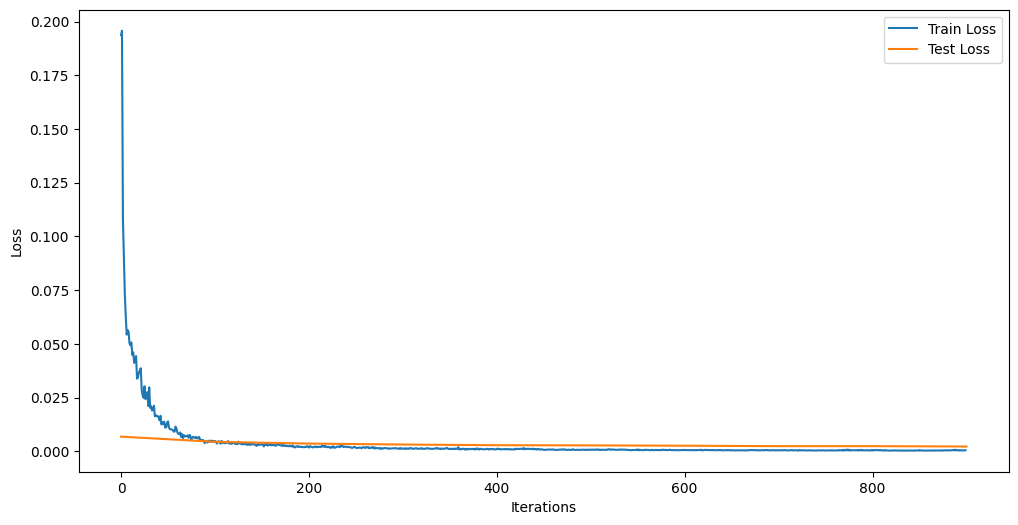

In [46]:
plot_losses(train_losses, test_losses)

In [50]:
# Make train and val loaders
val_mask = get_val_mask(dataset.replay_buffer.n_episodes, 0.1)
val_idxs = np.where(val_mask)[0]
train_idxs = np.where(~val_mask)[0]

# Make the episode dataset and create a DataLoader.
batch_size = 256
n_obs_history = 4
n_pred_horizon = 0
process_img_fn = lambda img: img / 255.0
train_episode_dataset = EpisodeDataset(
    dataset,
    n_obs_history=n_obs_history,
    n_pred_horizon=n_pred_horizon,
    episode_idxs=train_idxs,
    process_img_fn=process_img_fn,
)
val_episode_dataset = EpisodeDataset(
    dataset,
    n_obs_history=n_obs_history,
    n_pred_horizon=n_pred_horizon,
    episode_idxs=val_idxs,
    process_img_fn=process_img_fn,
)
train_loader = torch.utils.data.DataLoader(
    train_episode_dataset, batch_size=batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_episode_dataset, batch_size=batch_size, shuffle=False
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
hidden_dims = None
N, H, W, C = dataset.replay_buffer["img"].shape
N, action_dim = dataset.replay_buffer["action"].shape
cnn_id_model = InverseDynamicsCNN(
    C, H, W, action_dim, n_obs_history, hidden_dims=hidden_dims
).to(device)
img_normalizer = get_image_range_normalizer()
train_losses, test_losses = train_epochs(
    cnn_id_model,
    train_loader,
    val_loader,
    img_normalizer,
    action_normalizer,
    opt_kwargs={"lr": 1e-4},
    num_epochs=10,
    log_freq=None,
    save_freq=2,
    save_dir=None,
)

Preparing data:   0%|          | 0/185 [00:00<?, ?it/s]

Preparing data:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Batch:   0%|          | 0/88 [00:00<?, ?it/s]

Batch:   0%|          | 0/88 [00:00<?, ?it/s]

/tmp/ipykernel_3746688/2594059924.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs_history["img"] = torch.tensor(obs_history["img"], dtype=torch.float32)
/tmp/ipykernel_3746688/2594059924.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs_history["action"] = torch.tensor(obs_history["action"], dtype=torch.float32)
/tmp/ipykernel_3746688/2594059924.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred_horizon["img"] = torch.tensor(pred_horizon["img"], dtype=torch.float32)
/tmp/ipykernel_3746688/2594059924.py:85: UserWarni

Batch:   0%|          | 0/88 [00:00<?, ?it/s]

Batch:   0%|          | 0/88 [00:00<?, ?it/s]

Batch:   0%|          | 0/88 [00:00<?, ?it/s]

Batch:   0%|          | 0/88 [00:00<?, ?it/s]

Batch:   0%|          | 0/88 [00:00<?, ?it/s]

Batch:   0%|          | 0/88 [00:00<?, ?it/s]

Batch:   0%|          | 0/88 [00:00<?, ?it/s]

Batch:   0%|          | 0/88 [00:00<?, ?it/s]

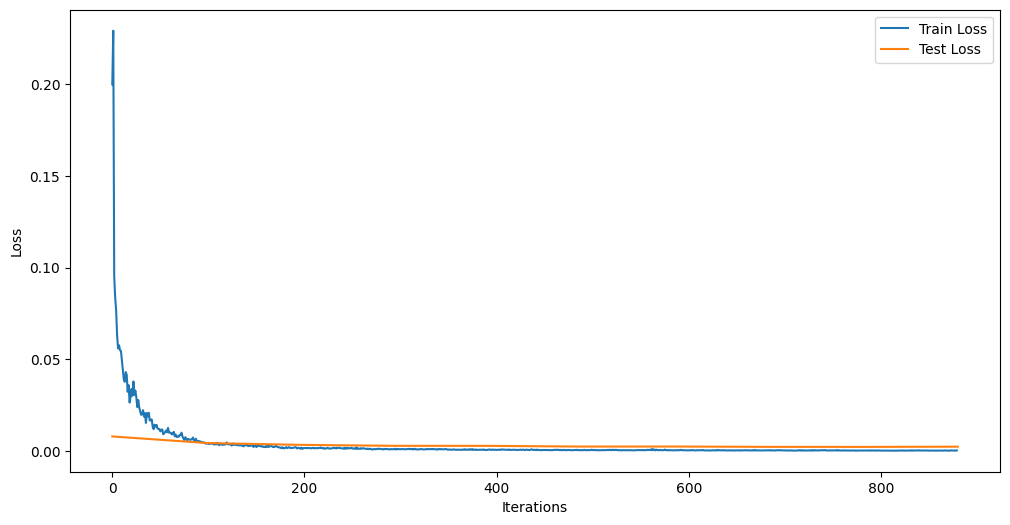

In [51]:
plot_losses(train_losses, test_losses)

In [96]:
# Evaluate the model on the validation set.
test_loss = eval(model, val_loader, criterion, device)
print("Final Test Loss:", test_loss)

Final Test Loss: 0.0022563826699801216


In [97]:
# Get the true and predicted action for a test batch.
model.eval()
with torch.no_grad():
    cur_img, next_img, action = next(iter(val_loader))
    cur_img = img_normalizer(cur_img)
    next_img = img_normalizer(next_img)
    action = action_normalizer(action)

    cur_img = cur_img.to(device)
    next_img = next_img.to(device)
    action = action.to(device)

    action_pred = model(cur_img, next_img)

# Unnormalize the action prediction
unnormalized_action = action_normalizer.unnormalize(action)
unnormalized_action_pred = action_normalizer.unnormalize(action_pred)
normalized_mse = criterion(action, action_pred)
unnormalized_mse = criterion(unnormalized_action, unnormalized_action_pred)

print("Normalized MSE:", normalized_mse.item())
print("Unnormalized MSE:", unnormalized_mse.item())

Normalized MSE: 0.0026286058127880096
Unnormalized MSE: 160.71157836914062


In [98]:
(unnormalized_action[:5], unnormalized_action_pred[:5])

(tensor([[435., 183.],
         [426., 187.],
         [425., 187.],
         [429., 195.],
         [437., 205.]]),
 tensor([[430.6378, 200.1248],
         [435.4316, 197.3025],
         [441.2008, 200.1139],
         [440.7962, 198.5584],
         [439.3036, 213.0943]]))

In [43]:
# Load the model.
model = InverseDynamicsCNN(C, H, W, action_dim).to(device)
model.load_state_dict(torch.load("inverse_dynamics_cnn_final.pt"))

<All keys matched successfully>